# Delta Function

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [3]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


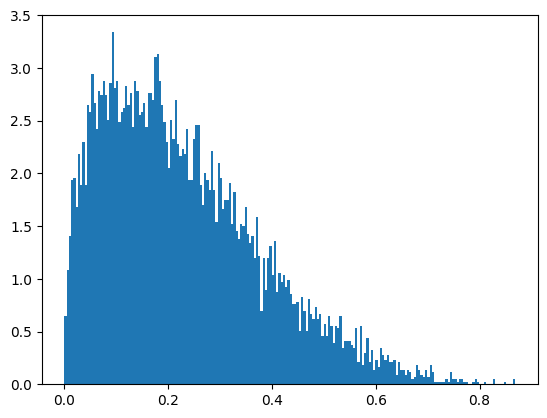

In [4]:
import matplotlib.pyplot as plt

values = plt.hist(np.random.beta(1.5, 5, 10000),

                  bins=200, density=True)

plt.show()

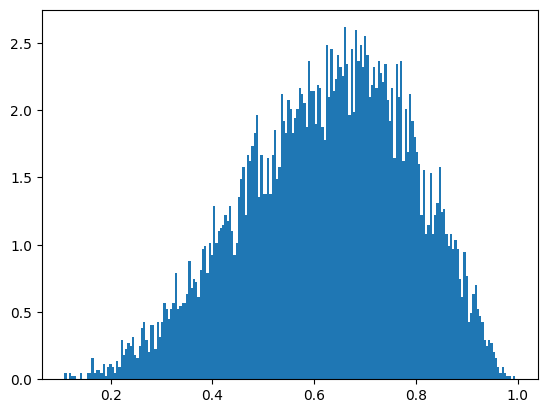

In [5]:
import matplotlib.pyplot as plt

values = plt.hist(np.random.beta(5, 3, 10000),

                  bins=200, density=True)

plt.show()

In [6]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        # self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        a = 5 # shape
        rng = np.random.default_rng()
        
        
        # race
        self.race =  rng.binomial(1,0.2)#binary not white0.2 /  white for the moment 0.8
        
        if self.race == 0:
            self.wealth = rng.beta(self.p.wealth_low_0, 5,1)[0]
        else:
            self.wealth = rng.beta(5, self.p.wealth_high_1,1)[0]
            

        # fraud
        self.fraud = rng.binomial(1,0.5,1)[0]
        self.fraud_pred = -1
        self.convicted = 0

        
    def fraud_algo(self):
        """ DM mechanism can also be ML"""
        rng = np.random.default_rng()
        # self.fraud_pred = rng.binomial(1, 0.5)
        if self.fraud == 1:
            fraud_cor = rng.binomial(1,self.p.acc)
        else:
            fraud_cor = rng.binomial(1,1-self.p.acc)
            
        self.fraud_pred = rng.binomial(1, fraud_cor*(0.8-self.p.wealth_appeal_corr))
        

    def appeal(self):
        """Possibility to Appeal to Fraud Algo Decision"""
        rng = np.random.default_rng()
#         print('bye')
        if self.fraud_pred == 1 and self.wealth > self.p.appeal_wealth:
            self.fraud_algo()
            # self.fraud_pred = rng.binomial(1, 0.4)
            
    def convict(self):
        """ Conviction and Consequences"""
        rng = np.random.default_rng()
        if self.fraud_pred == 1:
            if rng.binomial(1,0.8) == 1:
                # pay fine, get on record, 
                self.wealth = self.wealth - np.max([0.01,(self.wealth*0.05)])
                self.convicted =+ 1
                self.fraud = rng.binomial(1,0.5,1)[0]
                self.fraud_pred = 0
    
    def wealth_grow(self):
        self.wealth = min(1,self.wealth+pow(self.wealth,2)*0.01)
            
            
        


#     def step(self):
#         # The agent's step will go here.
#         # For demonstration purposes we will print the agent's unique_id
#         self.appeal()
#         print("Hi, I am agent " + str(self.unique_id) + ".")
#         # print("my wealth, job, fraud, fraud_pred is:" + str(self.wealth)+ str(self.job) + str(self.fraud)+ str(self.fraud_pred))

Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

In [7]:
class VirusModel_baseline(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """
        
        # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
        self.agents.fraud_algo()
#         self.agents.appeal()
        self.agents.convict()
        self.agents.wealth_grow()
        


    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
            
        
        
#         # Record final evaluation measures
#         self.report('Total share infected', self.I + self.R) 
#         self.report('Peak share infected', max(self.log['I']))

In [8]:
class VirusModel(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """
        
        # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
        self.agents.fraud_algo()
        self.agents.appeal()
        self.agents.convict()
        self.agents.wealth_grow()
        


    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
            
        
        
#         # Record final evaluation measures
#         self.report('Total share infected', self.I + self.R) 
#         self.report('Peak share infected', max(self.log['I']))

## Vizualisation

In [9]:
def viz(data, x, y, hue):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 hue = hue,
                 marker = 'o')

    plt.show()

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

Completed: 100 steps
Run time: 0:00:03.330353
Simulation finished


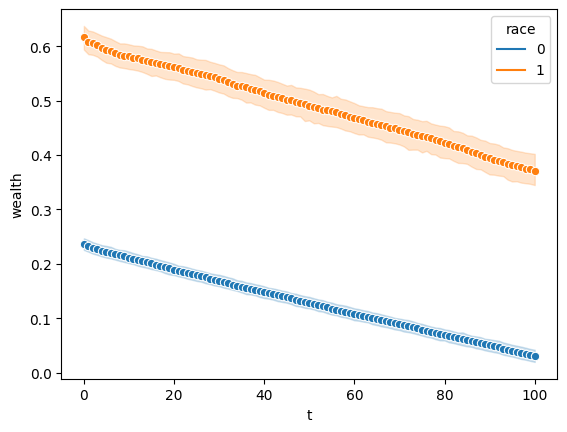

In [10]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.2, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    'wealth_low_0': 1.5, # shape of beta distribution for race 0
    'wealth_high_1': 3
}

model_baseline = VirusModel_baseline(parameters)
results_baseline = model_baseline.run() 

df_baseline = results_baseline['variables']['Person']

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['race'])

Completed: 100 steps
Run time: 0:00:04.583670
Simulation finished


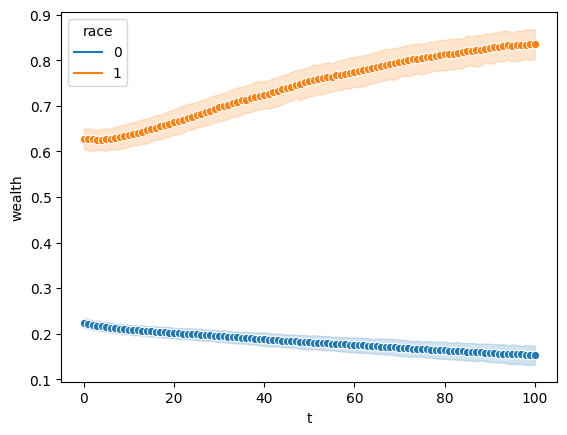

In [11]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.2, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    'wealth_low_0': 1.5, # shape of beta distribution for race 0
    'wealth_high_1': 3
}

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']

viz(df, df.index.get_level_values('t'), df['wealth'].astype(float), df['race'])

In [12]:
# create baseline value
df_b1 = df_baseline.iloc[(df_baseline['race'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['race'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

In [13]:
df_x1 = df.iloc[(df['race'] == 1).values] 
df_wb1 = df_x1['wealth'] - baseline1['wealth']
df_x1['wealth'] = df_wb1




df_x0 = df.iloc[(df['race'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])


/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_77251/2096043862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1['wealth'] = df_wb1
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_77251/2096043862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


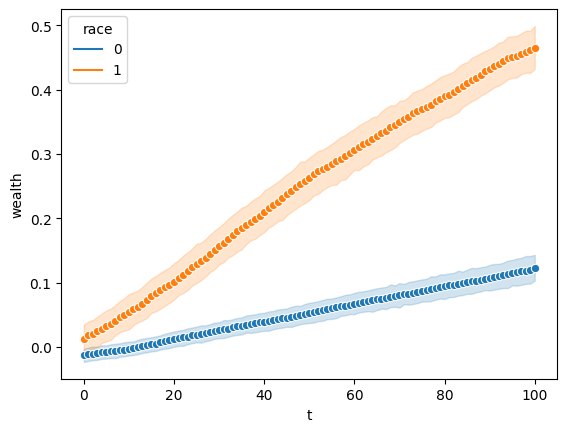

In [14]:
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

## Delta Function 

In [15]:
# run baseline and normal model and save results
model_baseline = VirusModel_baseline(parameters)
results_baseline = model_baseline.run() 

df_baseline = results_baseline['variables']['Person']

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']

Completed: 100 steps
Run time: 0:00:03.276820
Simulation finished
Completed: 100 steps
Run time: 0:00:04.679602
Simulation finished


In [16]:
# create baseline value
def delta_function(disc_axis, df, df_baseline):
    df_b1 = df_baseline.iloc[(df_baseline[disc_axis] == 1).values] 
    df_wb1 = df.iloc[(df[disc_axis] == 1).values] ['wealth'] - df_b1.groupby(level='t').mean()['wealth']
    df_x1['wealth'] = df_wb1
    
    df_b0 = df_baseline.iloc[(df_baseline[disc_axis] == 0).values] 
    df_wb0 = df.iloc[(df[disc_axis] == 0).values] ['wealth'] - df_b0.groupby(level='t').mean()['wealth']
    df_x0['wealth'] = df_wb0

    df_xb = pd.concat([df_x0, df_x1])
    
    return df_xb

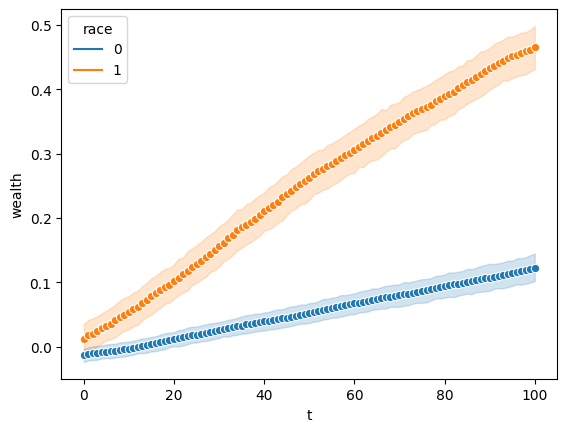

In [17]:
delta_function('race',df, df_baseline)
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

Do I want this or do I want just one line that indicates if r0 or r1 profits more?

## Sensitivity Analysis



1. First-order indices: measures the contribution to the output variance by a single model input alone.
2. Second-order indices: measures the contribution to the output variance caused by the interaction of two model inputs.
3. Total-order index: measures the contribution to the output variance caused by a model input, including both its first-order effects (the input varying alone) and all higher-order interactions.


### SALib

creates/samples model input and analyzes its out put with respect to its sensitivity.
Is independent from the computational model -> samples need to be looped over... 
=> seemes like last resort to me

### EMA Workbench
Powerful package with many different sesnitivity analysis.
Seems like maybe an overkill for now: https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/general-introduction.html


### Parameter sample module

used to sample multiple combinations from different parameter combinations \\
-> also possible to create interactive simulation (seems like a nice goal): https://agentpy.readthedocs.io/en/latest/guide_interactive.html [cant make the viz work]

seems like it covers everything

In [18]:
vm = VirusModel.as_function()
help(vm)



Help on function agentpy_model_as_function in module agentpy.model:

agentpy_model_as_function(**kwargs)
    Performs a simulation of the model 'VirusModel'.
    
    Arguments:
        **kwargs: Keyword arguments with parameter values.
    
    Returns:
        dict: Reporters of the model.



In [62]:
parameters = {
    'my_parameter':42,
    'agents':100,
    'steps':10,
    'wealth_appeal_corr': 0,# ap.Range(-0.2, 0.2), # >0 more wealth higher appeal chance
    'acc': 0.8, #ap.Range(0.5, 0.8), # accuracy of fraud prdediction
    'appeal_wealth': ap.Range(0, 0.5), # minimal wealth needed for appeal (could also become a param for distr. eventually)
    'wealth_low_0': ap.Range(1.5, 5), # shape of beta distribution for race 0
    'wealth_high_1': ap.Range(3, 5)
} 

sample = ap.Sample(
    parameters, 
    n=128, 
    method='saltelli', 
    calc_second_order=True
)

In [63]:
exp = ap.Experiment(VirusModel, sample, iterations=2, record = True)
results = exp.run()

Scheduled runs: 2048
Completed: 2048, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:46.211853


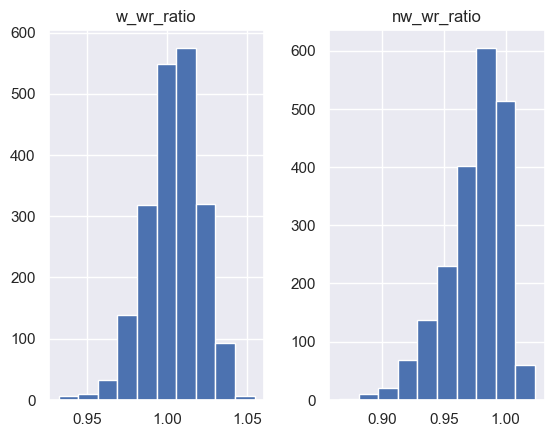

In [64]:
results.reporters.hist();

## Analyzing results

The simulation returns a :class:`DataDict` of recorded data with dataframes:

In [65]:
a =results['reporters']
a

seed  w_wr_ratio  \
sample_id iteration                                                        
0         0           34074225147061593285473396239664228682    1.030113   
          1          210607464755900620309199032000813413429    1.009155   
1         0          144250822050772795358830950582692587920    0.981864   
          1          123483442879542642986295156563407649749    1.020418   
2         0          323865972201748889594849443531330718228    1.031773   
...                                                      ...         ...   
1021      1          324843354455242119258508053534294918351    0.965123   
1022      0          249526039115845145820881964434829913209    1.005548   
          1          133808631733184943471414158515938843158    1.011283   
1023      0          163831418964420039185122579282490135490    0.977273   
          1          272021298608353301207745953357597671912    1.018257   

                     nw_wr_ratio  
sample_id iteration               
0         0             0.985361  
          1             0.975248  
1         0             0.990745  
          1             0.998611  
2         0             1.004632  
...                          ...  
1021      1             1.007862  
1022      0             0.986484  
          1             1.012351  
1023      0             0.987700  
          1             0.992098  

[2048 rows x 3 columns]

In [66]:
df = results['variables']['Person']
df

wealth  fraud_pred  fraud  race
sample_id iteration obj_id t                                    
0         0         1      0   0.425755          -1      1     0
                           1   0.427568           0      1     0
                           2   0.429396           0      1     0
                           3   0.409590           0      0     0
                           4   0.411268           0      0     0
...                                 ...         ...    ...   ...
1023      1         100    6   0.242674           0      0     0
                           7   0.243263           0      0     0
                           8   0.243855           0      0     0
                           9   0.244449           0      0     0
                           10  0.245047           0      0     0

[2252800 rows x 4 columns]

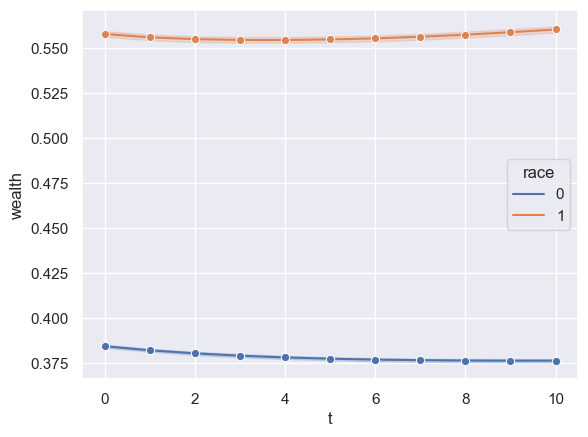

In [67]:
df = results['variables']['Person']
viz(df, df.index.get_level_values('t'), df['wealth'].astype(float),  df['race'])


## Multi-run experiment

To explore the effect of different parameter values, 
we use the classes :class:`Sample`, :class:`Range`, and :class:`IntRange`
to create a sample of different parameter combinations.

What I want is trying a bunch of 

We then create an :class:`Experiment` that takes a model and sample as input.
:func:`Experiment.run` runs our model repeatedly over the whole sample 
with ten random iterations per parameter combination.

Optionally, we can save and load our results as follows:

In [68]:
results.save()

Data saved to ap_output/VirusModel_7


In [69]:
results = ap.DataDict.load('VirusModel')

Loading from directory ap_output/VirusModel_7/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_Person.csv - Successful
Loading parameters_log.json - Successful


In [70]:
results['reporters']

seed  w_wr_ratio  \
sample_id iteration                                                        
0         0           34074225147061593285473396239664228682    1.030113   
          1          210607464755900620309199032000813413429    1.009155   
1         0          144250822050772795358830950582692587920    0.981864   
          1          123483442879542642986295156563407649749    1.020418   
2         0          323865972201748889594849443531330718228    1.031773   
...                                                      ...         ...   
1021      1          324843354455242119258508053534294918351    0.965123   
1022      0          249526039115845145820881964434829913209    1.005548   
          1          133808631733184943471414158515938843158    1.011283   
1023      0          163831418964420039185122579282490135490    0.977273   
          1          272021298608353301207745953357597671912    1.018257   

                     nw_wr_ratio  
sample_id iteration               
0         0             0.985361  
          1             0.975248  
1         0             0.990745  
          1             0.998611  
2         0             1.004632  
...                          ...  
1021      1             1.007862  
1022      0             0.986484  
          1             1.012351  
1023      0             0.987700  
          1             0.992098  

[2048 rows x 3 columns]

The measures in our :class:`DataDict` now hold one row for each simulation run.

In [71]:
a =results['parameters']['sample']
a

,appeal_wealth,wealth_low_0,wealth_high_1
sample_id,,,
0,0.005859,2.662109,3.585938
1,0.095703,2.662109,3.585938
2,0.005859,4.658203,3.585938
3,0.005859,2.662109,4.351562
4,0.005859,4.658203,4.351562
...,...,...,...
1019,0.001953,4.986328,4.960938
1020,0.001953,3.646484,4.960938
1021,0.287109,4.986328,4.960938


In [72]:
results['reporters']

seed  w_wr_ratio  \
sample_id iteration                                                        
0         0           34074225147061593285473396239664228682    1.030113   
          1          210607464755900620309199032000813413429    1.009155   
1         0          144250822050772795358830950582692587920    0.981864   
          1          123483442879542642986295156563407649749    1.020418   
2         0          323865972201748889594849443531330718228    1.031773   
...                                                      ...         ...   
1021      1          324843354455242119258508053534294918351    0.965123   
1022      0          249526039115845145820881964434829913209    1.005548   
          1          133808631733184943471414158515938843158    1.011283   
1023      0          163831418964420039185122579282490135490    0.977273   
          1          272021298608353301207745953357597671912    1.018257   

                     nw_wr_ratio  
sample_id iteration               
0         0             0.985361  
          1             0.975248  
1         0             0.990745  
          1             0.998611  
2         0             1.004632  
...                          ...  
1021      1             1.007862  
1022      0             0.986484  
          1             1.012351  
1023      0             0.987700  
          1             0.992098  

[2048 rows x 3 columns]

We can use standard functions of the pandas library like 
:func:`pandas.DataFrame.hist` to look at summary statistics.

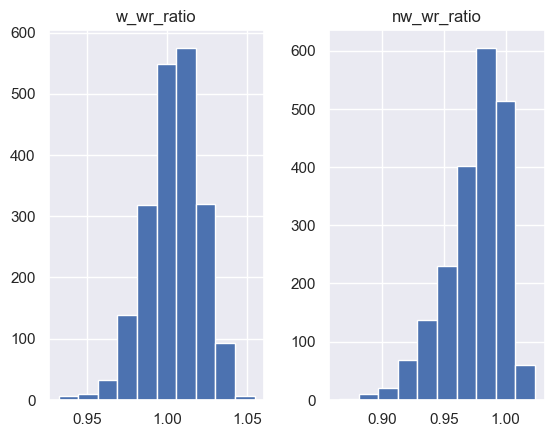

In [73]:
results.reporters.hist();

## Sensitivity analysis

The function :func:`DataDict.calc_sobol` calculates `Sobol sensitivity
indices <https://salib.readthedocs.io/en/latest/api.html#sobol-sensitivity-analysis>`_ 
for the passed results and parameter ranges, using the 
`SAlib <https://salib.readthedocs.io/en/latest/basics.html>`_ package. 

Explainer on satteli and sobol
https://towardsdatascience.com/sobol-indices-to-measure-feature-importance-54cedc3281bc

In [74]:
# can be parallelized
results.calc_sobol()

/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/agentpy/datadict.py:148: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reporters_df = self.reporters.groupby('sample_id').mean()


DataDict {
'parameters': 
    'sample': DataFrame with 3 variables and 1024 rows
    'constants': Dictionary with 5 keys
    'log': Dictionary with 5 keys
'reporters': DataFrame with 3 variables and 2048 rows
'info': Dictionary with 12 keys
'variables': 
    'Person': DataFrame with 4 variables and 2252800 rows
'sensitivity': 
    'sobol': DataFrame with 5 variables and 6 rows
    'sobol_conf': DataFrame with 5 variables and 6 rows
}

In [75]:
results['reporters']

seed  w_wr_ratio  \
sample_id iteration                                                        
0         0           34074225147061593285473396239664228682    1.030113   
          1          210607464755900620309199032000813413429    1.009155   
1         0          144250822050772795358830950582692587920    0.981864   
          1          123483442879542642986295156563407649749    1.020418   
2         0          323865972201748889594849443531330718228    1.031773   
...                                                      ...         ...   
1021      1          324843354455242119258508053534294918351    0.965123   
1022      0          249526039115845145820881964434829913209    1.005548   
          1          133808631733184943471414158515938843158    1.011283   
1023      0          163831418964420039185122579282490135490    0.977273   
          1          272021298608353301207745953357597671912    1.018257   

                     nw_wr_ratio  
sample_id iteration               
0         0             0.985361  
          1             0.975248  
1         0             0.990745  
          1             0.998611  
2         0             1.004632  
...                          ...  
1021      1             1.007862  
1022      0             0.986484  
          1             1.012351  
1023      0             0.987700  
          1             0.992098  

[2048 rows x 3 columns]

In [76]:
si_list = results.sensitivity.sobol.groupby(by='reporter')
si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')
results.sensitivity.sobol

order                            S1        ST            S2               \
parameter                                     appeal_wealth wealth_low_0   
reporter    parameter                                                      
w_wr_ratio  appeal_wealth  0.186717  0.808140           NaN    -0.147884   
            wealth_low_0  -0.138518  0.695407           NaN          NaN   
            wealth_high_1  0.108810  0.825432           NaN          NaN   
nw_wr_ratio appeal_wealth  0.346453  0.428476           NaN    -0.031843   
            wealth_low_0   0.518180  0.624164           NaN          NaN   
            wealth_high_1  0.016999  0.088547           NaN          NaN   

order                                    
parameter                 wealth_high_1  
reporter    parameter                    
w_wr_ratio  appeal_wealth     -0.156165  
            wealth_low_0       0.000812  
            wealth_high_1           NaN  
nw_wr_ratio appeal_wealth     -0.147778  
            wealth_low_0      -0.019212  
            wealth_high_1           NaN

This adds a new category `sensitivity` to our results, which includes:

- :attr:`sobol` returns first-order sobol sensitivity indices
- :attr:`sobol_conf` returns confidence ranges for the above indices

We can use pandas to create a bar plot that visualizes these sensitivity indices.


S1 for first order senstivity, ST for total, S2 for second order senstivity

order                            S1        ST            S2               \
parameter                                     appeal_wealth wealth_low_0   
reporter    parameter                                                      
nw_wr_ratio appeal_wealth  0.346453  0.428476           NaN    -0.031843   
            wealth_low_0   0.518180  0.624164           NaN          NaN   
            wealth_high_1  0.016999  0.088547           NaN          NaN   

order                                    
parameter                 wealth_high_1  
reporter    parameter                    
nw_wr_ratio appeal_wealth     -0.147778  
            wealth_low_0      -0.019212  
            wealth_high_1           NaN  
order                S1        ST            S2                           
parameter                         appeal_wealth wealth_low_0 wealth_high_1
parameter                                                                 
appeal_wealth  0.346453  0.428476           NaN    -0.031843     -

StopIteration: 

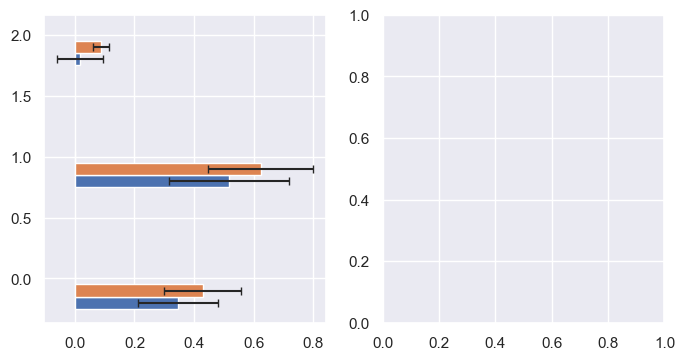

In [77]:
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """
    
    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by='reporter')
    si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        print(si)
        si = si.droplevel('reporter')
        print(si)
        err = err.droplevel('reporter')
        si.plot.barh(xerr=err, title=key, ax=ax, capsize = 3)
        ax.set_xlim(0)
    
    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[]) 
    axs[1].tick_params(left=False)
    plt.tight_layout()
    
plot_sobol(results)

Alternatively, we can also display sensitivities by plotting 
average evaluation measures over our parameter variations. 

appeal_wealth


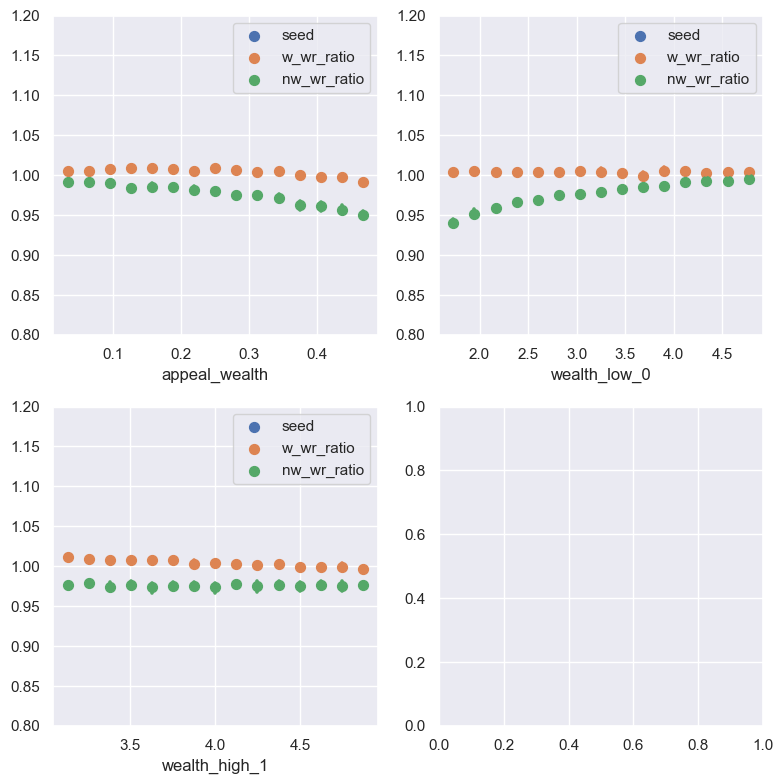

In [78]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j] # Flatten list
    
    data = results.arrange_reporters().astype('float')
    params = results.parameters.sample.keys() 
    print(params[0])
    
    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, 
                        x_bins=15, fit_reg=False, label=y)  
        ax.set_ylim(0.8,1.2)
        ax.set_ylabel('')
        ax.legend()
        
    plt.tight_layout()

plot_sensitivity(results)